In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
'''
实现四叉树图像压缩
'''

'\n实现四叉树图像压缩\n'

In [2]:
#结点类
class Node:
    def __init__(self, val, isLeaf, topLeft, topRight, bottomLeft, bottomRight):
        self.val = val                #用于存储颜色值
        self.isLeaf = isLeaf          #用于判断是否是叶子结点
        self.topLeft = topLeft        #四个分支
        self.topRight = topRight
        self.bottomLeft = bottomLeft
        self.bottomRight = bottomRight

In [95]:
#计算均方误差
def mse(grid):
    #grid是一个3通道的图像,计算每个通道的均方误差
    means = np.mean(grid, axis=(0, 1))
    errors = np.sum((grid - means) ** 2, axis=(0, 1)) / grid.size
    return means, np.sum(errors) / 3

#四叉树类
class QuadTree:
    def __init__(self, grid):
        self.grid = grid #grid是一个numpy数组
        if len(grid.shape) == 2:
            self.rows, self.cols = grid.shape[0], grid.shape[1]
            self.channel = 1
        else:
            self.rows, self.cols, self.channel = grid.shape
        #保证图像的长宽是2的整数次幂，将图像裁剪成2的整数次幂
        if self.rows & (self.rows - 1) != 0 or self.cols & (self.cols - 1) != 0:
            a = int(np.log2(self.rows))
            b = int(np.log2(self.cols))
            self.rows = self.cols = 2 ** min(a, b)
            #裁切图像
            self.grid = self.grid[:self.rows, :self.cols]
        self.root = self.compress(200)


    def compress(self, threshold):
        node = self._compress(0, 0, self.rows, self.cols, threshold)
        self.root = node
        return node
    
    def check(self, x1, y1, x2, y2, threshold):
        mean, error = mse(self.grid[x1:x2, y1:y2])
        return mean, error <= threshold  #如果均方误差小于阈值，就是叶子结点
    
    def _compress(self, x1, y1, x2, y2, threshold):
        if x1 == x2-1 and y1 == y2-1: #递归终止条件
            return Node(self.grid[x1, y1], True, None, None, None, None)
        mean, isLeaf = self.check(x1, y1, x2, y2, threshold)
        node = Node(mean, isLeaf, None, None, None, None)
        if isLeaf:
            return node
        midX, midY = (x1 + x2) // 2, (y1 + y2) // 2
        node.topLeft = self._compress(x1, y1, midX, midY, threshold)
        node.topRight = self._compress(x1, midY, midX, y2, threshold)
        node.bottomLeft = self._compress(midX, y1, x2, midY, threshold)
        node.bottomRight = self._compress(midX, midY, x2, y2, threshold)
        return node
    
    def decompress(self):
        grid = np.zeros((self.rows, self.cols, self.channel))
        self._decompress(self.root, 0, 0, self.rows, self.cols, grid)
        return grid
    
    def _decompress(self, node, x1, y1, x2, y2, grid):
        if node.isLeaf:
            #我想要有边界线条，也就是每个区块的边界都是黑色的
            grid[x1:x2, y1:y2] = 80
            if x2 - x1 <= 5 and y2 - y1 <= 5:
                grid[x1:x2, y1:y2] = node.val
            else:
                grid[x1+1:x2-1, y1+1:y2-1] = node.val
                
            # grid[x1:x2, y1:y2] = node.val #不要边界线的话就用这句代码
            return
        midX, midY = (x1 + x2) // 2, (y1 + y2) // 2
        self._decompress(node.topLeft, x1, y1, midX, midY, grid)
        self._decompress(node.topRight, x1, midY, midX, y2, grid)
        self._decompress(node.bottomLeft, midX, y1, x2, midY, grid)
        self._decompress(node.bottomRight, midX, midY, x2, y2, grid)

    def show(self):
        img = self.decompress()
        img = img.astype(np.uint8)
        #显示原图和压缩后的图
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(self.grid, cmap='gray')
        ax[0].set_title('Original Image')
        ax[1].imshow(img, cmap='gray')
        ax[1].set_title('Compressed Image')
        plt.show()



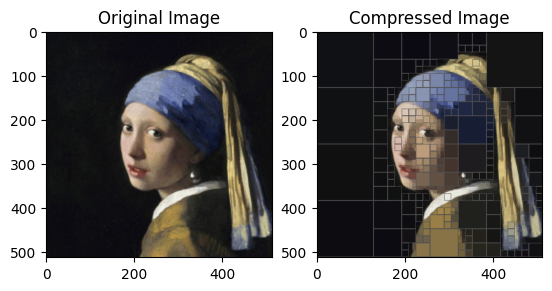

In [108]:
img = cv2.imread('./image/1.jpg')
img = cv2.imread('./image/2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
quadTree = QuadTree(img) 
quadTree.compress(100)
quadTree.show()

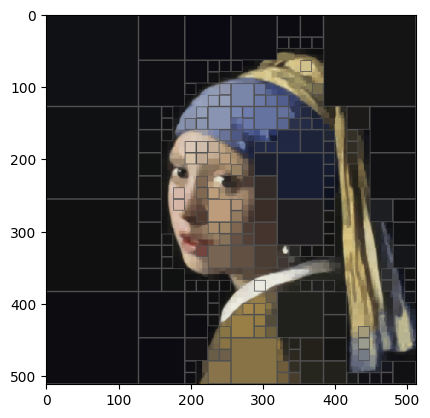

In [109]:
img = quadTree.decompress()
img = img.astype(np.uint8)
plt.imshow(img)